In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy
import matplotlib.lines as mlines

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 
for j in range(300):
    model.step()

There are 0 agents unassigned!!
128
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Annual crops  is de crop type
Annual crops  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Annual crops  is de crop type
Rice  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Annual crops  is de crop type
Aquaculture  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Annual crops  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Annual crops  is de crop type
Annual crops  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Aquaculture  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Rice  is de crop type
Aquacultur

In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Average_Livelihood,Num_household_members,Migrated_households,Migrated_members,Migrated_individuals,Died agents,Child births
0,0.000000,1000,0,0,0,0,0
1,0.375485,840,42,158,3,0,0
2,0.404654,840,43,162,5,0,6
3,0.403191,828,45,171,9,11,18
4,0.409956,813,47,182,13,20,27
5,0.409513,804,48,183,15,31,32
6,0.410270,794,48,183,23,45,44
7,0.409051,787,51,197,24,46,53
8,0.411346,780,53,204,27,49,59
9,0.408362,777,56,214,28,50,68


In [4]:
agent_data = model.datacollector.get_agent_vars_dataframe()

agent_savings = agent_data[agent_data['Savings'].notna()]
agent_savings


Crop_type Land_category       Savings  too low income
Step AgentID                                                          
1    1001             Rice         small  1.000000e+06             NaN
     1002             Rice         small  1.000000e+06             NaN
     1003             Rice         large  1.000000e+06             NaN
     1004     Annual crops        medium  1.000000e+06             NaN
     1005     Annual crops        medium  1.000000e+06             NaN
...                    ...           ...           ...             ...
300  1267             None          None  2.889362e+09             0.0
     1272             None          None  2.109971e+09             0.0
     1273             None          None  3.184880e+09             0.0
     1274             None          None  3.336776e+09             0.0
     1275             None          None  2.084446e+09             0.0

[5431 rows x 4 columns]

In [5]:
iksnaphetniet = agent_data
# Eerst filteren op relevante stappen
steps_of_interest = [12, 300]
filtered = iksnaphetniet.loc[steps_of_interest]

# Tel crop types per stap
counts = filtered.groupby(level=0)["Crop_type"].value_counts()

# Netjes printen
print(counts)


Step  Crop_type      
12    Annual crops       34
      Rice               33
300   Annual crops       43
      Perennial crops     9
      Rice                9
      Aquaculture         1
Name: count, dtype: int64


In [6]:
agent_landless = agent_data[agent_data['too low income'].notna()]

agent_landless = agent_landless[agent_landless['too low income']==1]
agent_landless = agent_landless.reset_index()
agent_landless['Year'] = agent_landless['Step']//12

agent_landless = agent_landless.groupby('Year').size().reset_index(name="Too low income count")
agent_landless

,Year,Too low income count
0,1,23
1,2,12
2,3,15
3,4,15
4,5,17
5,6,18
6,7,17
7,8,18
8,9,18
9,10,18


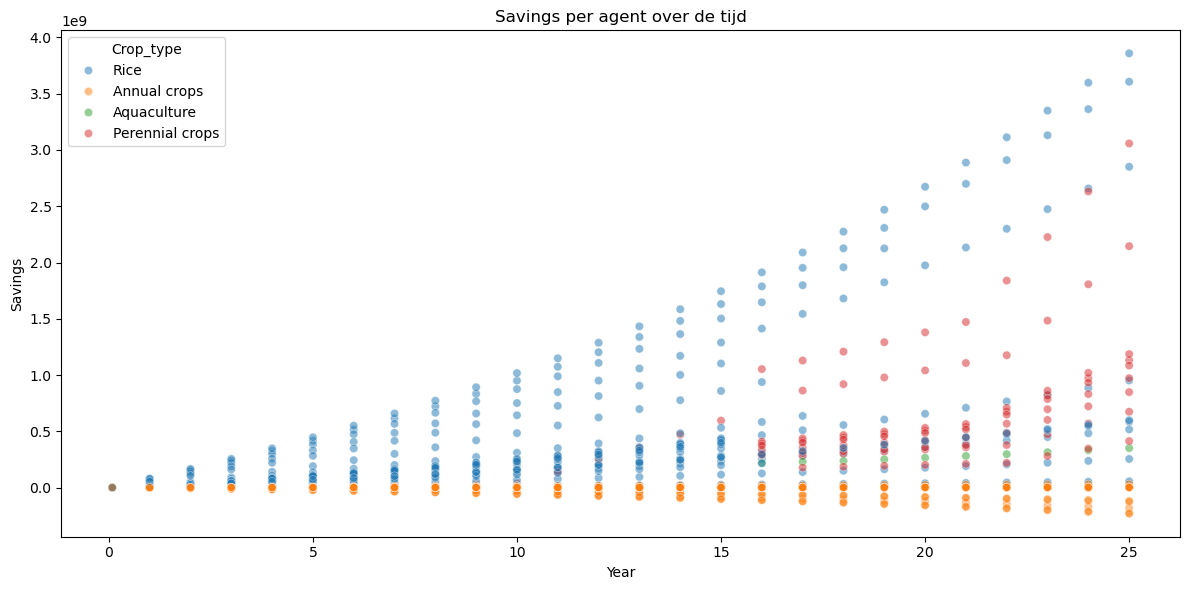

In [7]:
# agent_savings = agent_savings[agent_savings['Crop_type'].notna()]


agent_savings = agent_savings.reset_index() 
agent_savings['Year'] = agent_savings['Step'] / 12

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.scatterplot(data=agent_savings, x='Year', y='Savings', hue='Crop_type', alpha=0.5)
plt.title("Savings per agent over de tijd")
plt.ylabel("Savings")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

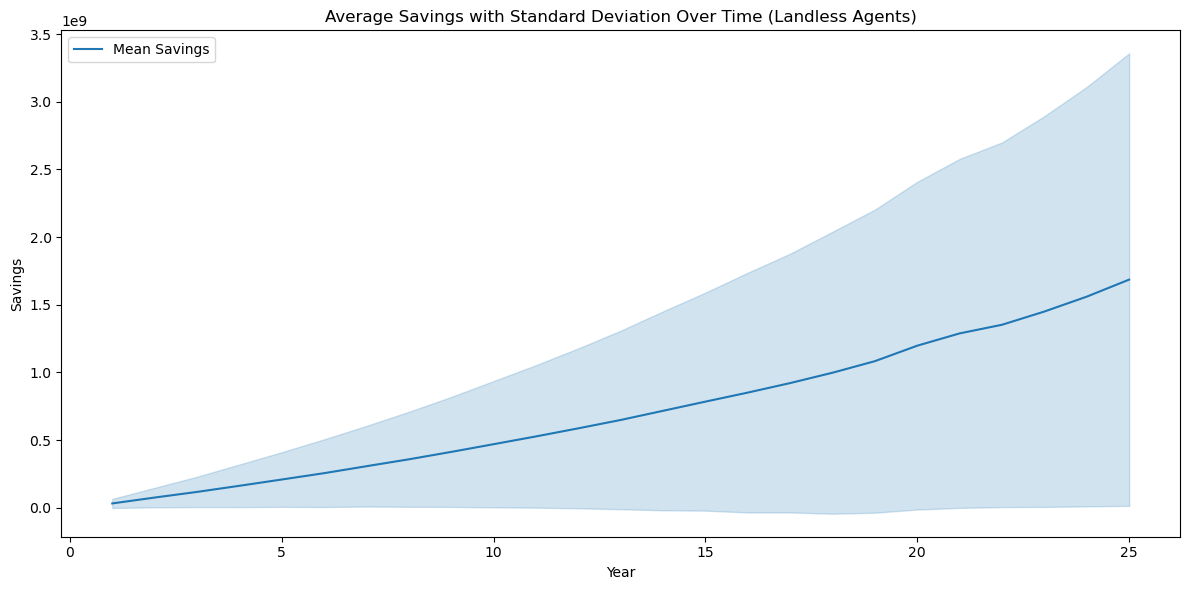

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter landless agents
landless_savings = agent_data[agent_data['too low income'].notna()].reset_index()
landless_savings['Year'] = landless_savings['Step'] / 12


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=landless_savings,
    x="Year",
    y="Savings",
    errorbar='sd',  
    estimator="mean",
    label="Mean Savings",
    ci="sd"  
)

plt.title("Average Savings with Standard Deviation Over Time (Landless Agents)")
plt.xlabel("Year")
plt.ylabel("Savings")
plt.tight_layout()
plt.show()



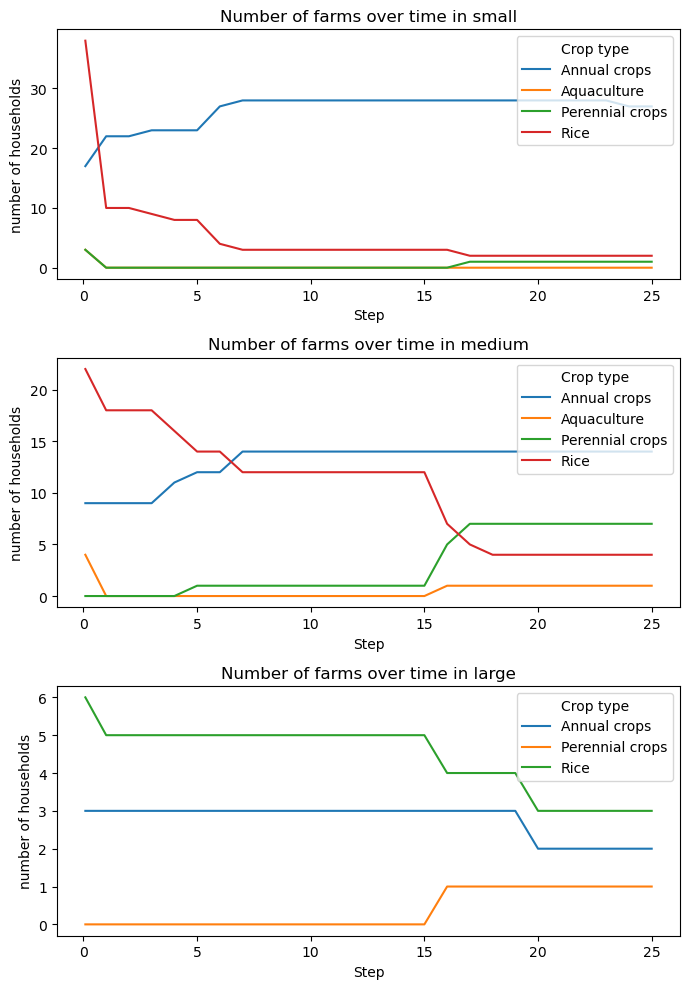

In [9]:
agent_data_crops_per_land = agent_data[agent_data['Crop_type'].notna()]
agent_data_crops_per_land

fig, axes = plt.subplots(nrows = 3, ncols= 1, figsize = (7,10))

for i, category in enumerate(['small', 'medium', 'large']):
    subsets = agent_data_crops_per_land[agent_data_crops_per_land["Land_category"]==category]
    if len(subsets) > 0:
        subsets = subsets.reset_index()
        subsets = subsets.groupby(['Step', "Crop_type"]).size().reset_index(name = "count")
        subsets = subsets.pivot(index = "Step", columns = "Crop_type", values = "count").fillna(0)
        subsets.index = subsets.index / 12
        subsets.plot(ax=axes[i])
        axes[i].set_title(f"Number of farms over time in {category}")
        axes[i].set_ylabel("number of households")
        axes[i].legend(title = "Crop type")
    
plt.xlabel("Step")
plt.tight_layout()
plt.show()

# agent_data_crops_per_land = agent_data_crops_per_land.reset_index().groupby(['Step', "Crop_type", "Land_category"]).size().reset_index(name = "count")
# agent_data_crops_per_land.plot(kind="line", figsize = (10,6))
#
# plt.title("Crop type distribution over time")
# 

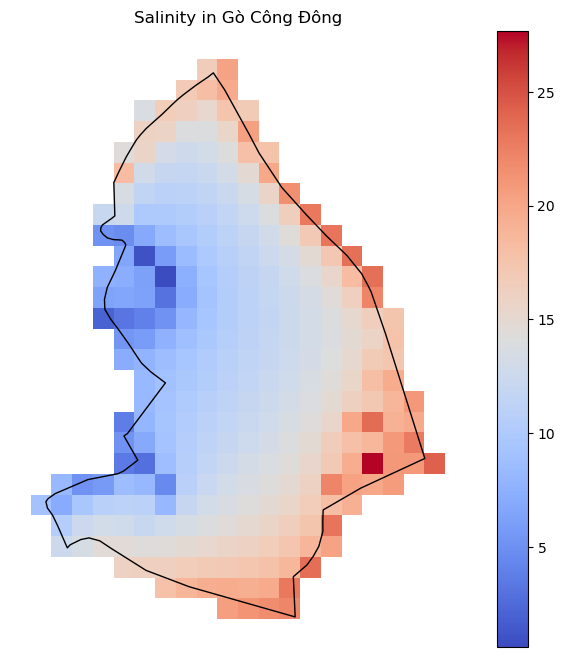

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)
model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {model.district}")
plt.axis("off")
plt.show()

105
62


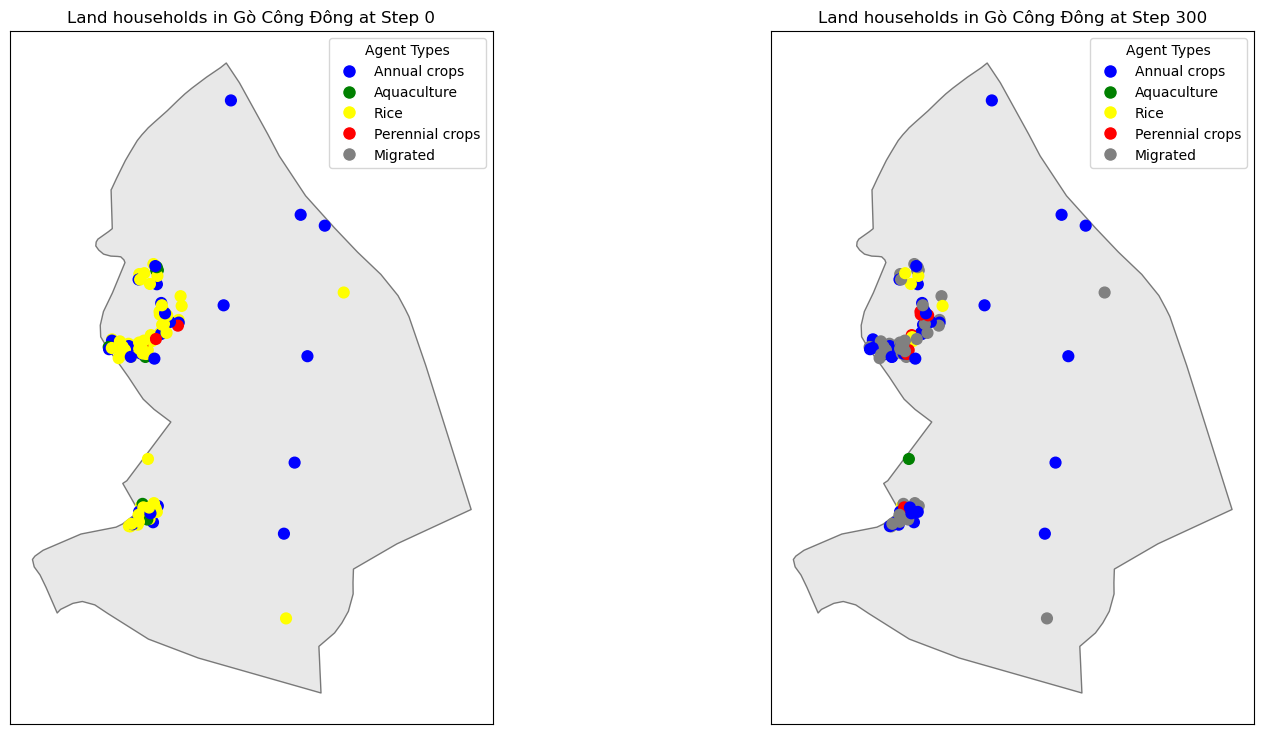

In [11]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households

def plot_network(ax, model):
    ax.clear()

    # Plot district map
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Get node positions
    pos = nx.get_node_attributes(model.G, 'pos')
    

    # Map node_id to agent
    node_to_agent = {agent.node_id: agent for agent in model.agents if isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))}
    print(len(node_to_agent))
    # Prepare lists for nodes and their colors
    nodes_to_draw = []
    colors_to_draw = []

    for node_id in model.G.nodes():
        nodes_to_draw.append(node_id)
        agent = node_to_agent.get(node_id)
        if agent:
            if agent.crop_type == "Annual crops":
                colors_to_draw.append('blue')
            elif agent.crop_type == "Aquaculture":
                colors_to_draw.append('green')
            elif agent.crop_type == "Rice":
                colors_to_draw.append('yellow')
            elif agent.crop_type == "Perennial crops":
                colors_to_draw.append('red')
            else:
                colors_to_draw.append("gray")  # unknown crop
        else:
            colors_to_draw.append("gray")  # migrated / no agent

    # Draw edges first (optional)
    #nx.draw_networkx_edges(model.G, pos, ax=ax, edge_color="gray")

    # Draw nodes with matching colors
    nx.draw_networkx_nodes(model.G, pos,
                           nodelist=nodes_to_draw,
                           node_color=colors_to_draw,
                           node_size=60,
                           ax=ax)

    # Add legend
    blue_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Annual crops')
    green_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', markersize=10, label='Aquaculture')
    yellow_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Rice')
    red_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Perennial crops')
    grey_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Migrated')
    ax.legend(handles=[blue_patch, green_patch, yellow_patch, red_patch, grey_patch], loc='upper right', title='Agent Types')

    ax.set_title(f"Land households in {model.district} at Step {model.steps}", fontsize=12)

    # Call function above to plot the map
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 9))
plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plt.show()


105
62


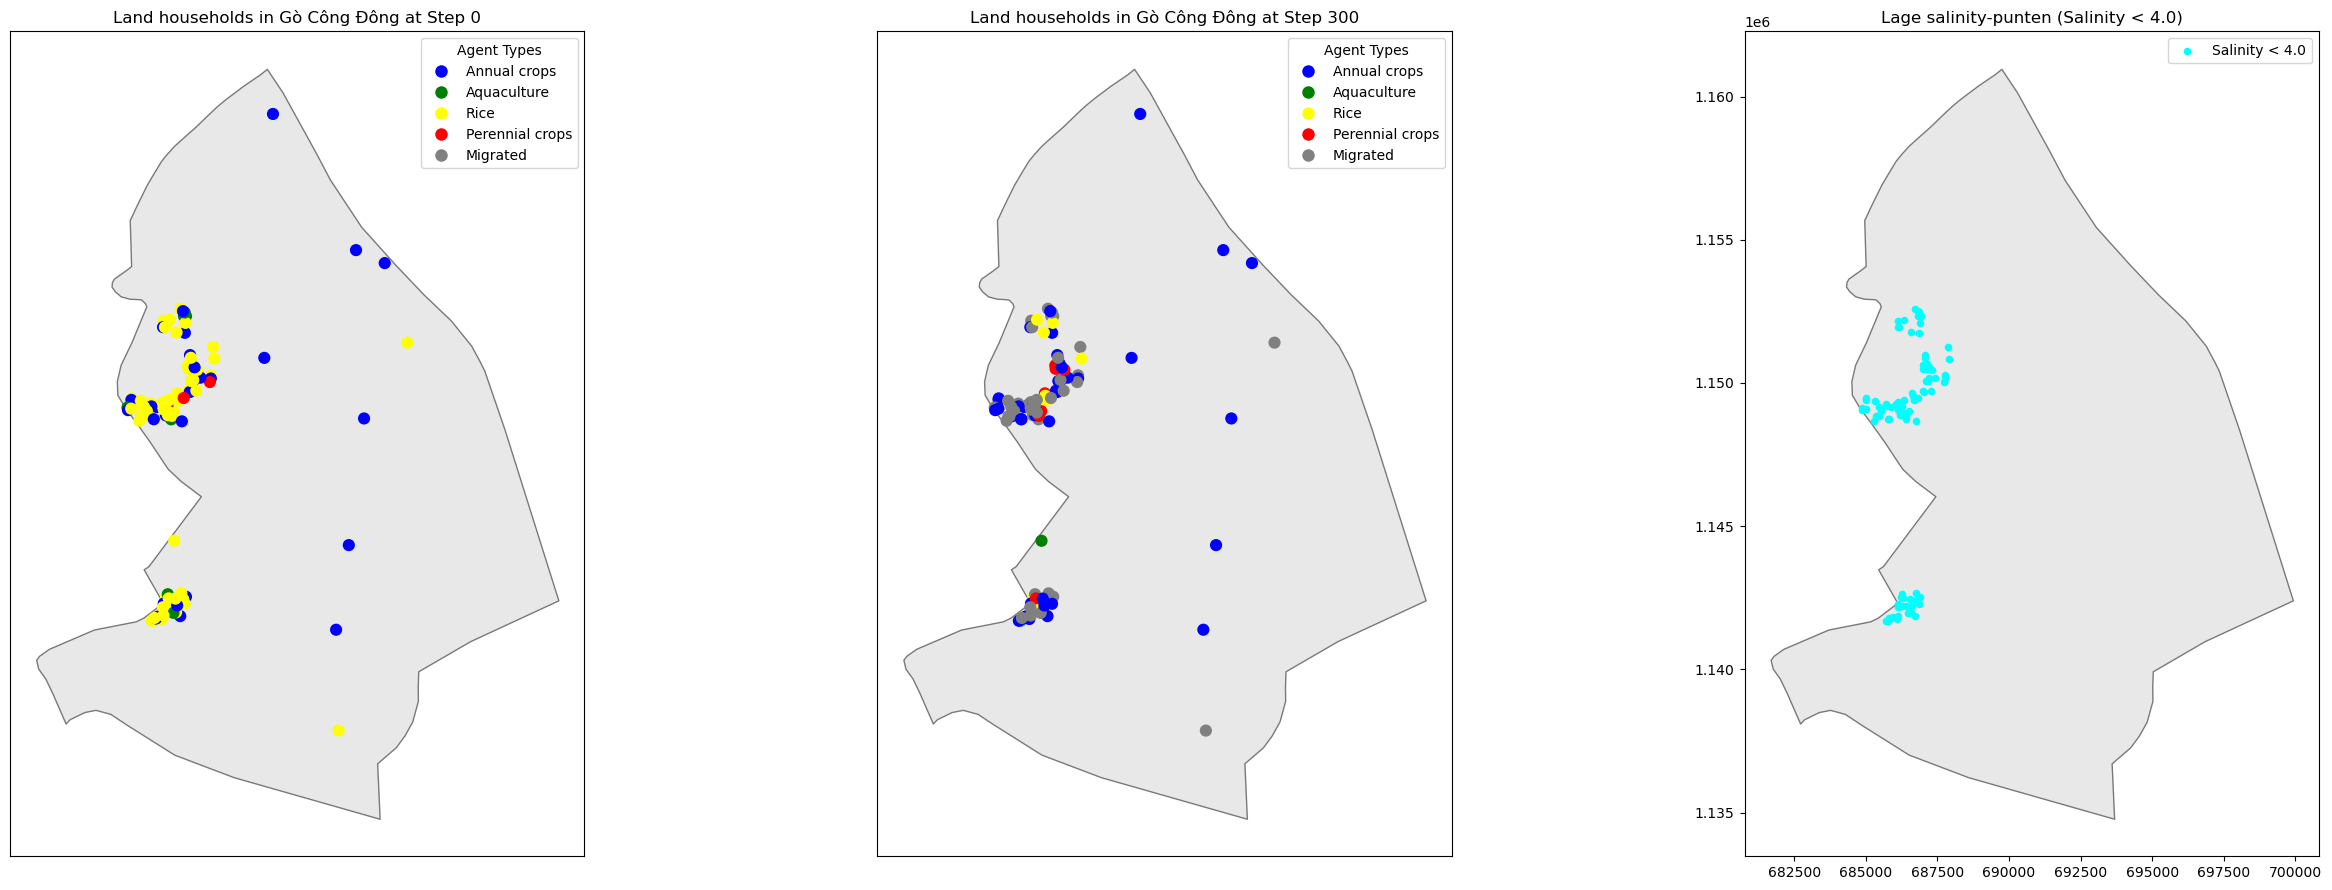

In [12]:
def plot_low_salinity_points(ax, model, threshold=4.0):
    ax.clear()

    # Plot district map als achtergrond
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    pos = nx.get_node_attributes(model.G, 'pos')
    salinities = nx.get_node_attributes(model.G, 'salinities')

    # Filter alleen nodes met salinity < threshold
    low_sal_nodes = [node for node, sal in salinities.items() if sal is not None and sal < threshold]

    low_sal_coords = [pos[node] for node in low_sal_nodes]

    # Plot deze punten
    if low_sal_coords:
        xs, ys = zip(*low_sal_coords)
        ax.scatter(xs, ys, color='cyan', s=20, label=f'Salinity < {threshold}')

    ax.set_title(f"Lage salinity-punten (Salinity < {threshold})", fontsize=12)
    ax.legend()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 9))

plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plot_low_salinity_points(ax3, model)

plt.tight_layout()
plt.show()


NameError: name 'districts_polygon' is not defined

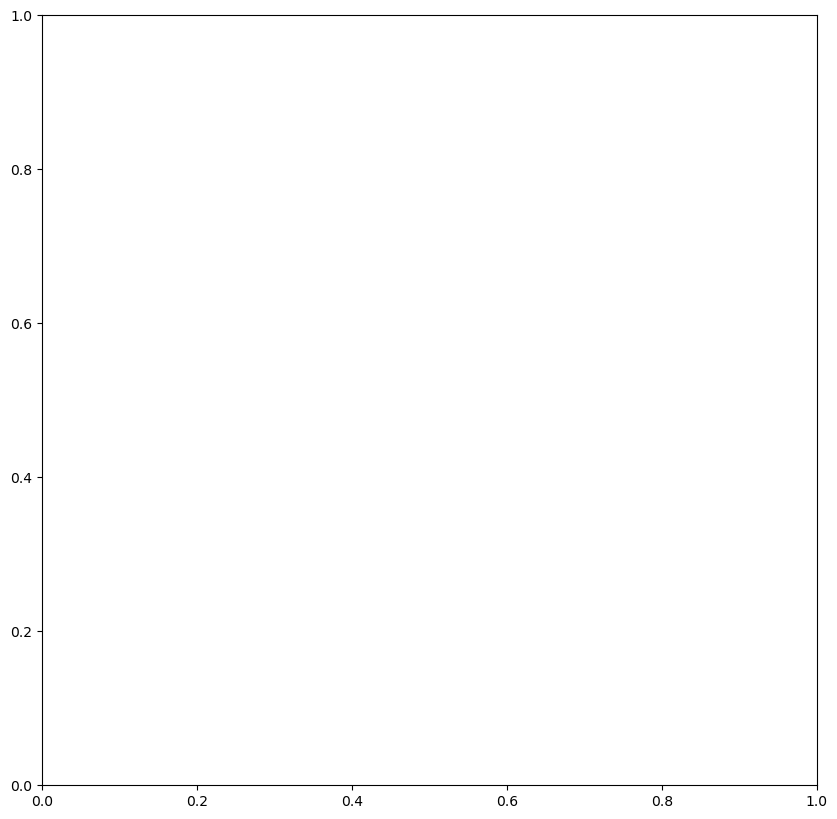

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point


# Verzamel salinity, posities en crop_type per node
positions = nx.get_node_attributes(model.G, "pos")
salinities = nx.get_node_attributes(model.G, "salinities")
crop_types = nx.get_node_attributes(model.G, "crop_type")  # als je dit hebt opgeslagen

# Maak lijst van punten (als shapely Point) en bijbehorende salinity
points = []
sals = []
colors = []

for node_id, (x, y) in positions.items():
    sal = salinities.get(node_id)
    crop = crop_types.get(node_id, "None")
    if sal is not None:
        points.append(Point(x, y))
        sals.append(sal)
        # Kleur op basis van salinity
        if sal < 4:
            colors.append("green")
        else:
            colors.append("red")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot de districten en salinity polygonen
model.districts_polygon.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
model.salinity_data.plot(column="Salinity", cmap="coolwarm", legend=True, ax=ax, alpha=0.4)

# Plot je agents als scatter
xs = [pt.x for pt in points]
ys = [pt.y for pt in points]

ax.scatter(xs, ys, c=colors, s=10, alpha=0.7, label="Agents")

# Optionele legenda
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Salinity < 4', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Salinity ≥ 4', markerfacecolor='red', markersize=8)
]
ax.legend(handles=legend_elements, title="Agent locatie op salinity")
ax.set_title("Agentlocaties vs. salinitykaart")

plt.show()
